# Japanese style poem generator

## 1. Introduction
This is an introduction and log book to the poem generator for the project “Bad Poet Society”. This generative system is based on a LSTM neural network with the data set construced by a mixture of Japanese haiku-like and waka-like English poems. 

I am a little bit familiar with Japanese, and also fond of Japanese literatures and poems (haiku, tanka, choka, et al.), therefore I decided to make a generative system regarding Japanese poems (though there is a struggling story about how I choose my inspiring set.. will reveal it later). 

At the first time I saw this project, the generative adversarial networks (GAN) instantly appeared in my thought. Due to the difficulty of exploiting a GAN and I was not familiar with it, I decided to make use of LSTM network for this generative system. I started checking the information regarding how to deploy a text generating LSTM, and the github [blog](https://gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b) by Maxim, the AI haiku [blog](https://www.brianweet.com/2019/06/16/write-ai-gpt-2-haiku.html) by brianweet, and the *haikurnn* project ([blog](https://towardsdatascience.com/generating-haiku-with-deep-learning-dbf5d18b4246), [code](https://github.com/docmarionum1/haikurnn/)) by Jeremy Neiman give me a lot of inspiration. 

### A simple analysis regarding two haiku projects by others with mine
Although brianweet's and Jeremy Neiman's ideas are very similar with mine, the expolitation of Brianweet's made use of GPT-2 model by OpenAI which is too huge to deploy for a small scale project such like mine, while Jeremy Neiman's project did not utilize word vectors (only word index and RNN) for training which is too much simple as a generator. Mine makes use of gensim word2vec for word vector training and LSTM network for generator training, which is an appropriate size for deploying this creativity system. 

## 2. Environment requirements
This scripts is in python3, with packages: 
* Keras
* Tensorflow
* pandas
* gensim
* numpy
* random

More information can be found in the README.md file in the zip archive.

In [135]:
import keras
import pandas as pd
import gensim
import numpy as np
import string

seed_value = 101
np.random.seed(seed_value)

import random
random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.callbacks import LambdaCallback
from keras.models import load_model

# import nltk
# from nltk import word_tokenize, pos_tag

#gpus = tf.config.experimental.list_physical_devices('GPU') # for cudnn
#tf.config.experimental.set_memory_growth(gpus[0], True)

import sys
sys.executable

'/usr/bin/python3'

In [78]:
# hyperparameter config
max_sentence_len=10
epoch_num = 5

## 3. About Inspiring set and the starting work
At the beginning I intended to code a completely traditional Japanese style English haiku generator, but due to the complexity of haiku composition, I was going to extend the spread of my inspiring set as the combination of haiku-like and waka-like Japanese poems. This set contains a ready-made haiku-like dataset provided by Jeremy Neiman's *haikurnn* project ([blog](https://towardsdatascience.com/generating-haiku-with-deep-learning-dbf5d18b4246), [code](https://github.com/docmarionum1/haikurnn/)).

### Compare traditional haiku and my haiku-like inspiring set
As described above, the inspiring set is essentially not a formal English haiku data set. 

The haiku poem has a constraint that it needs to have a 5-7-5 syllables formation. Originally this constraint is for Japanese for whom this seems easier to achieve compared with western language in which one atomic word may contain more than one sysllables while a Japanese hiragana has only one syllable. And there are more requirement for a haiku such like it needs the word describing the feature of a season. 

For variety and simplicity, I omit these harsh limits while preparing the inspiring set, and only reserve the restriction that the poem should have three sentences. My inspiring set is the dataset haikus.csv (140k haikus) from the *haikurnn* project in Github which I have mentioned before. Note that this data set in fact is also not a regular English haiku set. The author labeled the syllabels for every sentence of each poem where we could see that not every poem has a 5-7-5 formation but everyone has three sentences. Therefore I call this inspiring set as Haiku-like/Waka-like set (or to say in an explicit way, it is a Japanese poem inspiring set). 

More information about this data set can be found in their [blog](https://towardsdatascience.com/generating-haiku-with-deep-learning-dbf5d18b4246).

The example of this data set are shown as follows: 

In [4]:
# read the inspiring set 
# haiku-like dataset provided by the haikurnn 
# this 'scripts' dir will appear locally after you unzip the scripts.zip file
data = pd.read_csv("./scripts/data/haikus.csv")
data.head()

,0,1,2,source,0_syllables,1_syllables,2_syllables
0,Memorial Day --,a shadow for each,white cross,tempslibres,5,5,2
1,spring rain -,as the doctor speaks,i think of lilacs,tempslibres,"2,3",5,5
2,spring moonset --,a rice ball for,breakfast,tempslibres,"3,4",4,2
3,sunny afternoon,an old man lingers,near the mailbox,tempslibres,5,5,4
4,cinco de mayo,horses roll,in the shallows,tempslibres,5,3,4


## 4. Approach

### 4.1 Preparing the training set
This generator uses a simple LSTM neural network. For traning this network it needs a training set containing x and y. Here the strategy of training is to

* use the first sentence as *x* (source sentence) and the first word of the second sentence as *y* (target word)
* use the second sentence as *x* (source sentence) and the first word of the third sentence as *y* (target word)

Therefore I combine the first and second sentence of each poem together as the *train_x* list, and same procedure for the first words of second and third sentences as *train_y*, which makes each training sample is like this form: (form sentence, the first word of later sentence). Note that the order of sentences are remained which means the sentences are from the same poem in one traning sample. 

### 4.2 Pre-processing procedures
The pre-processing for traning text contains of:

* lowercase
* tokenize

Usually we could also do POS tagging, non-noun deleting, lemmatization, or other procedure. Here follow Maxim ([blog](https://gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b)) I only apply these two because the original text is already very short, and I need the word remaining its semantical conjuction formation for generating. (Here omit the complex processing procedure used in machine translation or other natural language processing generating task.)

In [5]:
sentences_x = data['0'].tolist()
sentences_y = data['1'].tolist()
sentences_y_p = data['2'].tolist()
print(len(sentences_x),len(sentences_y),len(sentences_y_p))

143137 143137 143137


In [11]:
# preparing sentences_tokens list for word2vec training
# for word2vec training, I use all of the sentences of the poems
# therefore it only needs to add all poems in one list 
# sentences' order in one poem is remained
# sentences_x_tokens et al. are prepared for training the generator model

sentences_x_tokens = [[word for word in str(sentence).lower().translate(str.maketrans('','', string.punctuation)).split()[:max_sentence_len]] for sentence in sentences_x]
sentences_y_tokens = [[word for word in str(sentence).lower().translate(str.maketrans('','', string.punctuation)).split()[:max_sentence_len]] for sentence in sentences_y]
sentences_y_p_tokens = [[word for word in str(sentence).lower().translate(str.maketrans('','', string.punctuation)).split()[:max_sentence_len]] for sentence in sentences_y_p]

sentences_tokens = []
for i in range(len(sentences_x_tokens)): # add blank to avoid missing tokenizing in next step
  sentences_tokens.append(sentences_x_tokens[i] + sentences_y_tokens[i] + sentences_y_p_tokens[i])
print(sentences_tokens[:5])

[['memorial', 'day', 'a', 'shadow', 'for', 'each', 'white', 'cross'], ['spring', 'rain', 'as', 'the', 'doctor', 'speaks', 'i', 'think', 'of', 'lilacs'], ['spring', 'moonset', 'a', 'rice', 'ball', 'for', 'breakfast'], ['sunny', 'afternoon', 'an', 'old', 'man', 'lingers', 'near', 'the', 'mailbox'], ['cinco', 'de', 'mayo', 'horses', 'roll', 'in', 'the', 'shallows']]


In [12]:
# train the word2vec model, using default config
# note that in gensim.model.Word2vec, the default method is CBOW
# and negative sampling will be user, where negative = 5
word_model = gensim.models.Word2Vec(sentences_tokens, size=50, min_count=1, window=5, iter=100)
pretrained_weights = word_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape

In [14]:
# to save or to load the trained word2vec model
# word_model.save('word2vec.model')
# word_model = gensim.models.Word2Vec.load('scripts/word2vec.model')

In [ ]:
# this is used to check the trained word vectors
"""
print('Checking similar words:')
for word in ['model', 'network', 'train', 'learn']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))
"""

In [145]:
def word2idx(word):
  return word_model.wv.vocab[word].index
def idx2word(idx):
  return word_model.wv.index2word[idx]

In [169]:
sentences_x_train = sentences_x_tokens + sentences_y_tokens
sentences_y_train = sentences_y_tokens + sentences_y_p_tokens
train_x = np.zeros([len(sentences_x_train), max_sentence_len], dtype=np.int32)
train_y = np.zeros([len(sentences_y_train)], dtype=np.int32)
for i, sentence in enumerate(sentences_x_train):
  for t, word in enumerate(sentence):
    train_x[i, t] = word2idx(word)
  if sentence!=[] and sentences_y_train[i]!=[]:
    train_y[i] = word2idx(sentences_y_train[i][0])
train_x

array([[ 2690,    51,     0, ...,     0,     0,     0],
       [  308,   201,     0, ...,     0,     0,     0],
       [  308, 16884,     0, ...,     0,     0,     0],
       ...,
       [   16,   441,   142, ...,     0,     0,     0],
       [  412,  1047, 43922, ...,     0,     0,     0],
       [  884,   376,    34, ...,     0,     0,     0]], dtype=int32)

In [170]:
np.shape(train_x)

(286274, 10)

In [171]:
np.shape(train_y)

(286274,)

In [172]:
# build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size, name='x1'))
model.add(Dense(units=vocab_size, name='y1'))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

### 4.3 LSTM neural networks
During experiments, I have tried both one-way LSTM and BiLSTM, and several numbers of epochs. I find BiLSTM would more easily overfit (the reason could be the sentence is very short) and takes more time for training (due to the issues of school computer I could not use GPU of the machine). Therefore I deploy only one-way LSTM network for this system.
![image.png](attachment:image.png "An example of RNN")
<center>An example of RNN showing how RNN type networks encode words in chronological order (image from <a href="http://torch.ch/blog/2016/07/25/nce.html">torch</a>).</center>

### 4.4 Generating procedure
After training we could use this LSTM model to generate the poem!
The generating procedure makes use of tempreture sampling mechanism to tune the randomness of the generating results. The higher the temperature, the more diverse results it gives (see a [blog](https://keras.io/examples/generative/lstm_character_level_text_generation/) regarding deploying it from Keras, a nice [blog](https://medium.com/machine-learning-at-petiteprogrammer/sampling-strategies-for-recurrent-neural-networks-9aea02a6616f) by Daniël Heres, and a [QA](https://cs.stackexchange.com/questions/79241/what-is-temperature-in-lstm-and-neural-networks-generally) webpage interpreting it from stackexchange).

During my experiments I indeed find if the value of tempreture is too low then the network will keep generating the same word with the input. Therefore I tune up this value as 1.0.

I also write a noun-word-extracting script (see the next block) for the condition when one wants to start the poem by a noun word (it can be a verb, a adjective, or other limitations whatsoever as well). Though due to time limitation it is not well-equipped, it can be a part of future work. 

The generating part (function *generate_next(text, num_generated)*) itself is provided by the github [code](https://gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b) which has been mentioned as the very beginning of this logbook. But there are a few modification of mine: 
* a) instead of generate 10 words for each sentence, I generate two words for the first sentence (in which the first word is random chosen by the funtion *random.choice* from the overall vocabulary of the word2vec model) (this can be also seen as the stopping criterion of this generating system). The second sentence is generated by input of the first sentence, similarly, the third sentence is generated by the second sentence as the input.
* I write a function *poem_generator(random_start)* for generating a single haikulike poem which gives a better layout. 

More generated poems can be found on my website [blog](http://qaqawwv.nl/2020/11/02/ai-poet/ 'blog').
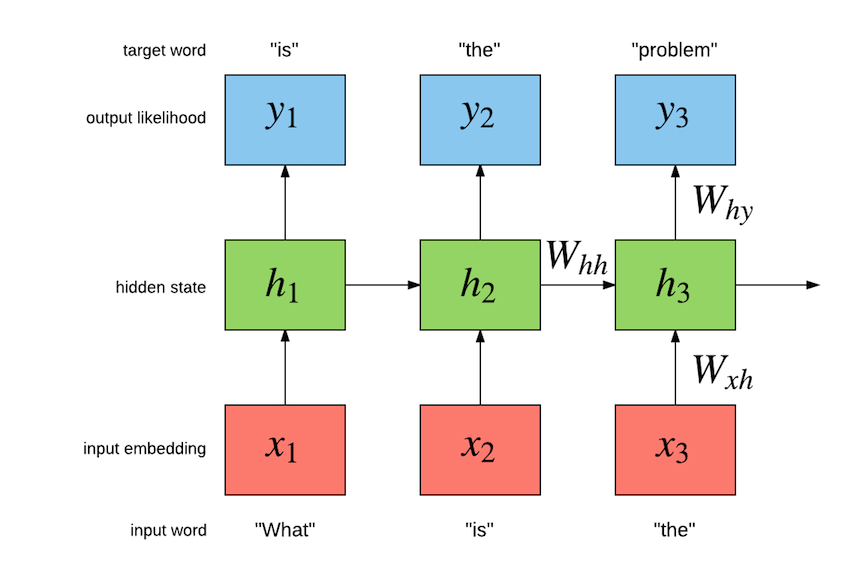

In [174]:
# this temperature-tuned generating mechanism is a sample 
# from keras for generating rnn
# see "Character-level text generation with LSTM"
# link: https://keras.io/examples/generative/lstm_character_level_text_generation/

def sample(preds, temperature=1.0):
  if temperature <= 0:
    return np.argmax(preds)
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)
 
def generate_next(text, num_generated=10):
  word_idxs = [word2idx(word) for word in text.lower().split()]
  for i in range(num_generated):
    prediction = model.predict(x=np.array(word_idxs))
    idx = sample(prediction[-1], temperature=1.0)
    word_idxs.append(idx)
  return ' '.join(idx2word(idx) for idx in word_idxs)

vocab = word_model.wv.vocab.keys()
random_start = random.choice(tuple(vocab))
def poem_generator(start):
  first_sen = generate_next(start, num_generated=2)
  second_sen = generate_next(first_sen, num_generated=5)
  third_sen = generate_next(second_sen, num_generated=3)
  return [first_sen, " ".join(second_sen.split()[-5:]), " ".join(third_sen.split()[-3:])]

def callback_ep(epoch, _):
  random_start = random.choice(tuple(vocab))
  haikulike_ep = poem_generator(random_start)
  print('\r')
  print(haikulike_ep[0])
  print(haikulike_ep[1])
  print(haikulike_ep[2])

In [175]:
model.fit(train_x, train_y,
          batch_size=64,
          epochs=epoch_num,
          callbacks=[LambdaCallback(on_epoch_end=callback_ep)])

Epoch 1/5
4472/4474 [============================>.] - ETA: 0s - loss: 6.8104
cents slicked breathtaking
clown settles watchful commute valued
visit bummed falter
4474/4474 [==============================] - 102s 23ms/step - loss: 6.8103
Epoch 2/5
4474/4474 [==============================] - ETA: 0s - loss: 6.1739
trying favourite of
dames lenses carriages rations scumbag
spheres placards astaroth
4474/4474 [==============================] - 103s 23ms/step - loss: 6.1739
Epoch 3/5
4473/4474 [============================>.] - ETA: 0s - loss: 5.9097
trents placements intended
pronounced demented chopped comfy gov
explained cows sorry
4474/4474 [==============================] - 103s 23ms/step - loss: 5.9097
Epoch 4/5
4474/4474 [==============================] - ETA: 0s - loss: 5.7409
hosting bored each
is tracking artist byu orientation
weep essay asks
4474/4474 [==============================] - 103s 23ms/step - loss: 5.7409
Epoch 5/5
4473/4474 [============================>.] - ETA: 0s

In [176]:
model.save("./scripts/LSTM_TG.model")
#model = load_model("./scripts/LSTM_TG.model")

INFO:tensorflow:Assets written to: ./scripts/LSTM_TG.model/assets


In [196]:
# this is used when you want to 
# assign a noun word as the 
# beginning of the poem for checking the generating system
"""
NN_words = set()
def noun_words_extract(sentences):
  for s in sentences:
    if type(s)!=float:
      s_tokens_C = word_tokenize(s)
      s_pos_tag = pos_tag(s_tokens_C)
      for i in s_pos_tag:
        if 'NN' in i[-1]:
          NN_words.add(i[0])
noun_words_extract(sentences_x)
noun_words_extract(sentences_y)
noun_words_extract(sentences_y_p)
"""

In [177]:
print("Generating haiku-like poem...\n")
random_start = random.choice(tuple(vocab))
haikulike = poem_generator(random_start)
print(haikulike[0].capitalize())
print(haikulike[1].capitalize())
print(haikulike[2].capitalize())

Generating haiku-like poem...

Lemar methinks walked
Coworker fire flipped hollister pointing
Rigidity soggy austrian


## 5. Evaluation

### 5.1 contextualized embedding
A typical feature of this generating system is that, it is not a rule-based system. There is no written-rules (such like a expilicit grammar: where to place what words) to choose from. This system utilizes Word2vec model and LSTM, which could tackle with long-distance text and keep this information for training. (This is also the disadvantage of a Markov chian, which depends on the previous k words.)

For this system itself, Word2vec is a context-free method, while LSTM neural networks trains the word representation into context-dependent (although not very sensitive compared with BERT or other advanced models). 

### 5.2 creativity
Although one of the reasons that I do not apply POS restriction to generating is the time limitation of this building this system, I would like to check if there is no such restriction, how does the generator work. for evaluating this generative system, we could focus on next arguments regarding implementing SPECS (Jordanous, 2012):


Pro:

* Involvement and persistence: This system could generate a Japanese poem by randomly or manually choosing a word from the vocabulary;
* This system has learned the probability of whether a word could appear near other words (by Word2vec);
* Domain Competence & general intellect: This system could generate coherent poem sentences which can be interpreted manually by human. Some of its generating results even astonishing, such like: *sunlight shadowed even because inspiration*;
* Generation of Results (stopping criteria): It could stop after generating a fixed number of words.

Con:
* Uncertainty: It is not resilient with a out-of-vocabulary (OOV) input, as a mature generative text model could deal with a OOV word in some ways, e.g. assigning it a all-zeros vector;
* Domain Competence & general intellect: Sometimes the result is not as coherent as expected (e.g. repeatly generating the same words and need to tune the temperature carefully, regardless the of the basic English grammar such like the third person sigular);
* Generation of Results (stopping criteria): Although it could stop, the stop criteria is simple for a poem generator (e.g. do not consider syllables, the rhyme can not be guaranteed).

### some trifling remarks
I am not sure about the real reasons why the researchers would like to focus on poem generating, but for me, if I am going to construct a generating system, I feel like starting it from poem generating from scratch. The reason for me is that, poetry is a freestyle in literature world in no matter what language, which seems far away from logical writing such like reasoning and translation, because we do not limit that the poem needs to be written in a totally cohereant way: one could even put a verb at first, and a name at last for the rhyme. Typically, it is conceivable that the machine is better at 'logical thinking' -- better to do the above logical things, but when training it to write poem in a not-strictly-logical way then try to interpret it, is it creative to let it write something looks far from 'logical'? Here we do not depends on the verbose discussion about whether this machine gasps the language or not (Chinese room problem?), so long as it could 'say something plausible'.

## 6. Future work

### 6.1 About the inspiring set
The other part I would like to add as a component of this inspiring set is the English translation wakas in the game *The Ghost of Tsushima* -- a good Japanese style PS4 video game in which there are a lot of wakas composing materials that can be combined freely by the gamer, and thankfully the designers provided all of the English translation for the gamer. Each of these decent poems will also have three sentences. There are also numerous waka data set can be found on the Internet. Due to time limitation I do not put these wakas as an add-on part of inspiring set, but I think it is worthy to have a look in the future. 

### 6.2 Generator training
#### 6.2.1 for word vectors
The used word vectors can be enhanced -- I only use the sentences in the inspiring set for training. There are two ways: 
* a) use gensim pre-trained word vectors (there are a lot of options provided by [gensim API](https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html 'gensim API') which are trained by large scale corpora and very easy for using);
* b) use a much bigger corpus for training (can also use the corpora from gensim (see the above link) ).

in both ways the pre-processing procedures would also be modified.

#### 6.2.2 for neural networks and generated results
The network I use for training is a simple LSTM layer and the target is a single word. In natural language processing and generative text field, there are much advanced efficient models such like GAN ([Goodfellow et al.](https://arxiv.org/pdf/1406.2661.pdf)) BERT ([Google](https://arxiv.org/pdf/1810.04805.pdf)), GPT-2 ([OpenAI](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf)), or at least it can be added on basic inter or intra attention mechanism with some grammer modification method to refine the generated sentences as a further trail. 